# Reading DXD files directly in Python

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from tqdm import tqdm, trange
import xml.etree.ElementTree as ET

In [59]:
def tostr(A):
    """
    Converting a list of integers into characters
    """
    return ''.join([chr(x) for x in A])

def get_index(A,key):
    s = tostr(A)
    return s.find(key)

def get_addr(A,key, offset = 2):
    ind = get_index(A,key)
    if ind < 0:
        raise Execption('Not found')
        
    st = len(key) + ind + offset
    dt = np.dtype(np.uint32)
    dt = dt.newbyteorder('<')
#     print(A[st:st+8])
    return np.frombuffer(A[st:st+8],dtype=dt)[0]

def single_page_len(A, page_start):
    ind = page_start + 8
    while A[ind] >= 0xfe:
        ind += 1
    dt = np.dtype(np.uint32)
    dt = dt.newbyteorder('<')

    dtpn = np.dtype(np.int32)
    dtpn = dtpn.newbyteorder('<')

    prev_page = np.frombuffer(A[page_start+8:page_start+16], dtype=dtpn)[0]
    next_page = np.frombuffer(A[page_start+8+8:page_start+16+8], dtype=dtpn)[0]

    
    start = ind+4


    pg_type = np.frombuffer(A[ind:start], dtype=dt)[0]
    return np.frombuffer(A[start:start+4],dtype=dt)[0], start+4, A[page_start + 4], pg_type, prev_page, next_page
    

def get_page_len(A, page_start):
    return single_page_len(A, page_start)

## Reading the DXD file raw
This should be changed in reading the file in chunks so that the memory is not overloaded.
However, for the purpose of this notebook, we will read the file in one go.

In [60]:
A = np.fromfile('sin_freq_9_500000_20190319_073502.dxd',dtype='uint8')

## Locating the INDEX table

In [61]:
search = 'INDEX'
header = tostr(A[:2048])
ind = header.find(search)
st = len(search) + ind
dt = np.dtype(np.int16)
dt = dt.newbyteorder('<')
index_loc = np.frombuffer(A[st:st+2],dtype=dt)[0]

## Locating the SETUP XML page

In [62]:
B = A[index_loc:index_loc+2048]
xml_loc = get_addr(B,'SETUP',3)
hex(xml_loc)

'0xc00'

In [63]:

xml_data = []
pattern = [0xd, 0xa,0x00,0x00,0x00]
total_data = 0
while True:
    data_len, data_start, page_ser, pg_type, prev_page, next_page = get_page_len(A,xml_loc)
    data_start = xml_loc + 0x20
    if next_page > -1:
        xml_data.append(A[data_start:next_page])
        xml_loc = next_page
        total_data += len(A[data_start:next_page]) 
    else:
        n, m = 20480, len(pattern)
        indices = []
        for i in range(data_start,data_start + n - m + 1):
            if np.all(A[i:i+m] == pattern):
                end_ind = i
                break
        else:
            raise Exception()
        xml_data.append(A[data_start:end_ind])
        total_data += len(A[data_start:end_ind]) 
        break

In [64]:
root = ET.fromstring(tostr(np.concatenate(xml_data)).strip())
setup = list(root.iter('DewesoftSetup'))[0]
devices = setup.findall(".//Device[@Type='AI']")[0]
slots = devices.findall('.//Slot')

stored_channels = setup.findall(".//StoredChannels/Channel")
number_of_channels = sum(['AI' in x.attrib['Index'] for x in stored_channels])
print(f'Number of stored channels: {number_of_channels}')

Number of stored channels: 7


## Reading binnary data

In [65]:
db_loc = get_addr(B,'DBDATA')
hex(db_loc)

'0x11800'

Finding the table of contents and storing it in a dictionary where the page type is the key.

In [66]:
next_db_loc = db_loc
pages = []
while next_db_loc < len(A):
    data_len, data_start, page_ser, pg_type, prev_page, next_page = get_page_len(A,next_db_loc)
    # print(hex(next_db_loc), hex(data_len), page_ser)
    pages.append((data_len, data_start, page_ser, pg_type, prev_page, next_page))
    next_db_loc = data_start + data_len

sep_pages = {}
for page in pages:
    if page[3] not in sep_pages:
        sep_pages[page[3]] = []
    sep_pages[page[3]].append(page)

Types of pages in the file

In [67]:
sep_pages.keys()

dict_keys([6, 8, 9, 0, 10, 826753360, 545988715])

In [68]:
def load_page(data_len, data_start, page_ser, page_type, *args):
    dt = np.dtype(np.int16)
    dt = dt.newbyteorder('<')    
    return np.frombuffer(A[data_start:data_start+data_len],dtype=dt)

In [70]:
ext_data = []

ind = 0
tp = 6
wish = 0
carry_segment = np.array([])
for page in tqdm(sep_pages[tp]):
    B = load_page(*page)
    temp_arr = np.concatenate([carry_segment,B])
    fix_len = len(temp_arr)//(number_of_channels * 1000)
    reshaped_array = temp_arr[:fix_len*(number_of_channels*1000)].reshape(-1, 1000)

    carry_segment = temp_arr[-(len(temp_arr) % (number_of_channels * 1000)):]
    ext_data.append(reshaped_array[wish::number_of_channels,:].reshape(1,-1).squeeze())


100%|██████████| 6/6 [00:00<00:00, 449.34it/s]


Convert and scale the `uint` data into float

In [73]:
scale = setup.findall(f".//Slot[@Index='{wish}']/AmplScale")[0]
scale = float(scale.text)

interscept = setup.findall(f".//Slot[@Index='{wish}']/AmplOffset")[0]
interscept = float(interscept.text)

nsl = scale*10/(np.iinfo(np.uint16).max+1)
nsl, scale, interscept

(1.6104810129036257e-05, 0.105544483661652, -0.00645759241734273)

In [74]:
eI = np.concatenate(ext_data)*nsl - interscept

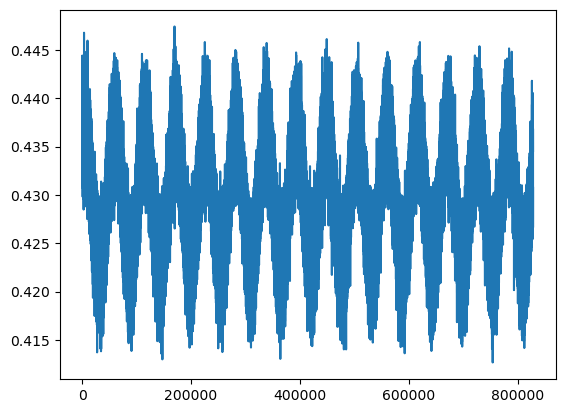

In [75]:
plt.plot(eI)